In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pycocotools
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import cv2
import os

In [2]:
pwd

'/home/shakyafernando/projects/Depth-Anything-V2/notebooks'

In [5]:
# Define directories
image_directory = '../data/depth-anything-v2-set2/images/' # Original Images
mask_directory = '../data/depth-anything-v2-set2/masks/' # Saved masks
csv_file = "../data/csv/depth-anything-v2-updated-with-annotations.csv" # CSV file

# Load the JSON file
coco = COCO('../data/depth-anything-v2-set2/annotations/instances_default.json') # .json file

os.makedirs(mask_directory, exist_ok=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [6]:
# Load the CSV file
data = pd.read_csv(csv_file)
data.head(5)
# list(data.columns)

,dataset,video_name,image_name,mask_name,frame,image_id,annotation_id,category_id,marker_id,size_m,...,range_m,Unnamed: 12,focal_length,path_to_file,Lx0,Ly0,Lx1,Ly1,segmentation,bbox
0,20240307-indoor,gp9-27_GX010042,gp9-27_GX010042_frame_0001.jpg,mask_gp9-27_GX010042_frame_0001_21.png,1,21.0,34.0,NaN,0,0.100,...,3.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[[1064.1, 460.7, 1063.1, 488.1, 1090.5, 488.6,...","[1063.1, 460.7, 27.7, 27.9]"
1,20240307-indoor,gp9-27_GX010042,gp9-27_GX010042_frame_0001.jpg,mask_gp9-27_GX010042_frame_0001_21.png,1,NaN,NaN,NaN,2,0.150,...,2.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20240307-indoor,gp9-27_GX010042,gp9-27_GX010042_frame_0001.jpg,mask_gp9-27_GX010042_frame_0001_21.png,1,NaN,NaN,NaN,3,0.127,...,1.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20240307-indoor,gp9-27_GX010043,gp9-27_GX010043_frame_0010.jpg,mask_gp9-27_GX010043_frame_0010_22.png,10,22.0,35.0,NaN,1,0.070,...,1.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[[528.5, 928.2, 526.9, 952.5, 549.2, 953.4, 57...","[526.9, 908.3, 45.1, 45.1]"
4,20240307-indoor,gp9-27_GX010043,gp9-27_GX010043_frame_0010.jpg,mask_gp9-27_GX010043_frame_0010_22.png,10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Function to create a color mask
def apply_color_mask(mask, color):
    """
    Apply the given color to the mask.
    Parameters:
    mask : 2D numpy array
        Binary mask with 0s and 1s.
    color : tuple
        RGB tuple (e.g., (255, 0, 0) for red).
    
    Returns:
    3D numpy array
        Colored mask.
    """
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for i in range(3):  # Apply color to each channel
        color_mask[:, :, i] = mask * color[i]
    return color_mask

In [8]:
# Get all image ids
image_ids = coco.getImgIds()
print(image_ids)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


/tmp/ipykernel_26203/3573429647.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 8))


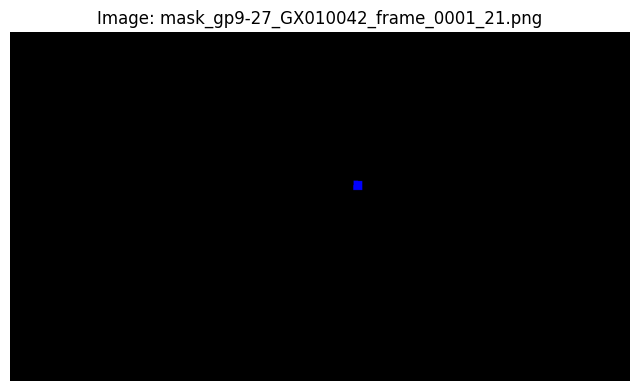

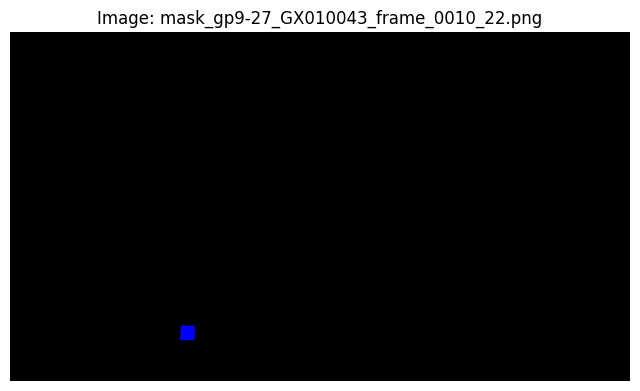

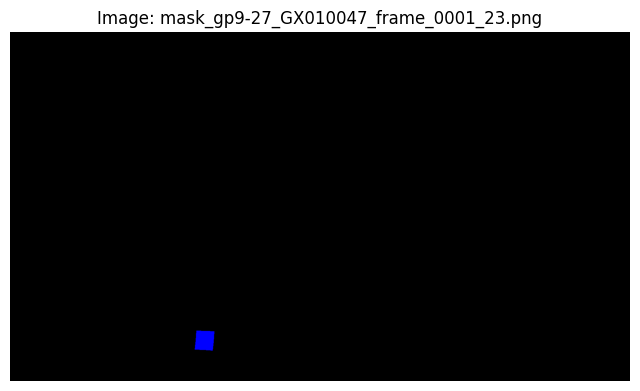

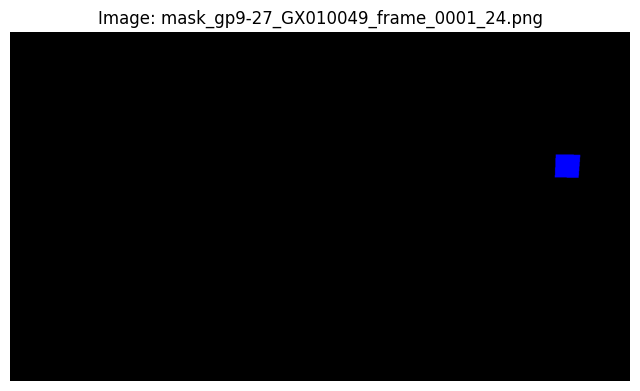

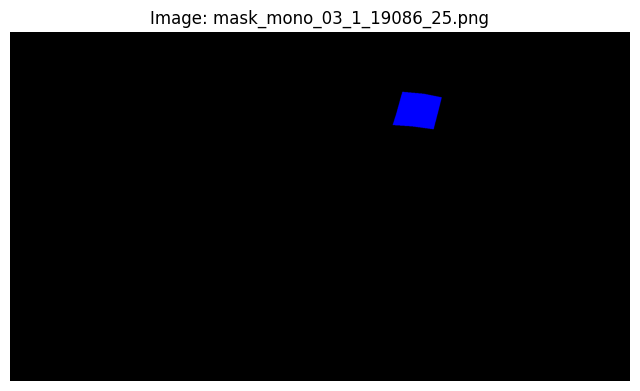

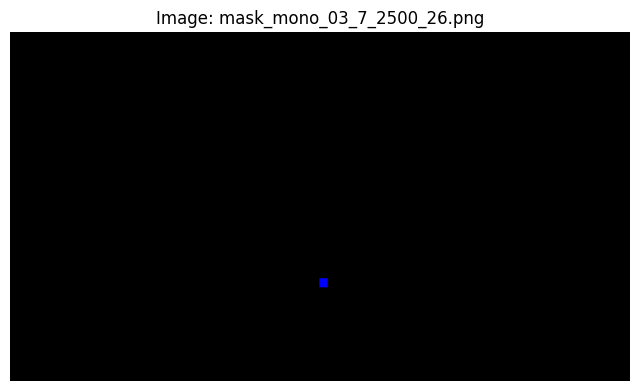

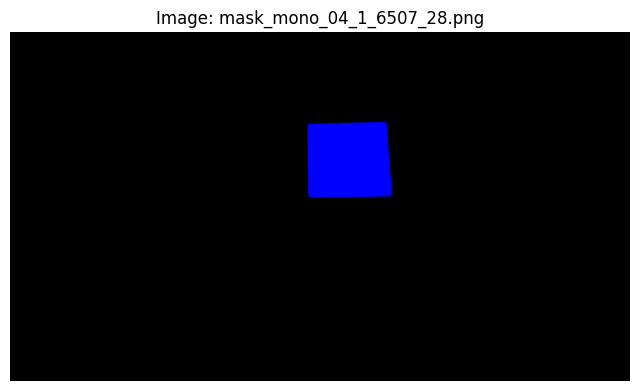

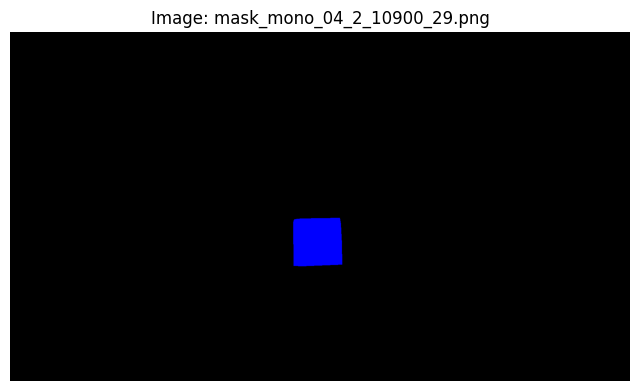

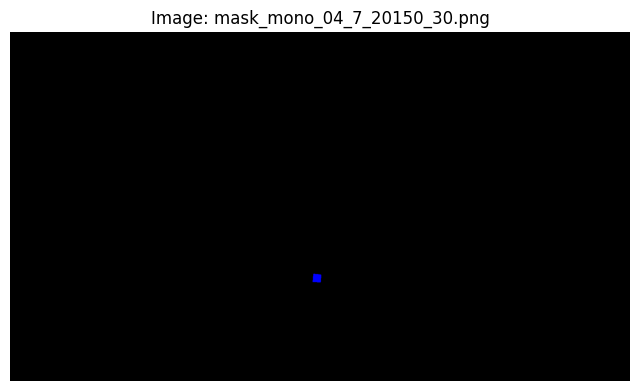

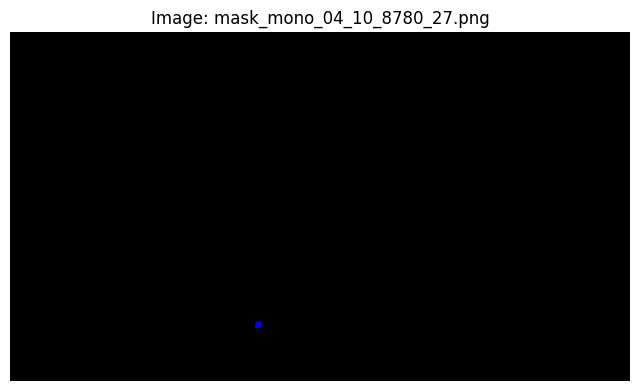

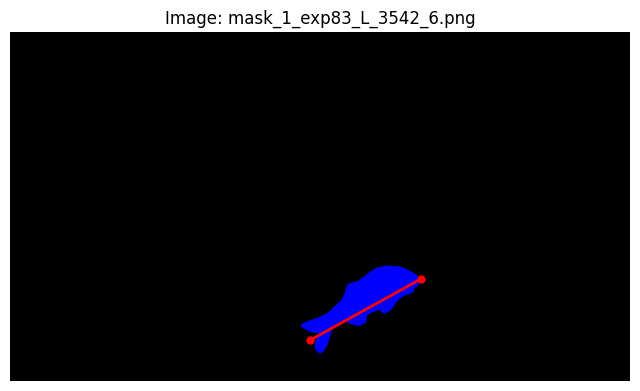

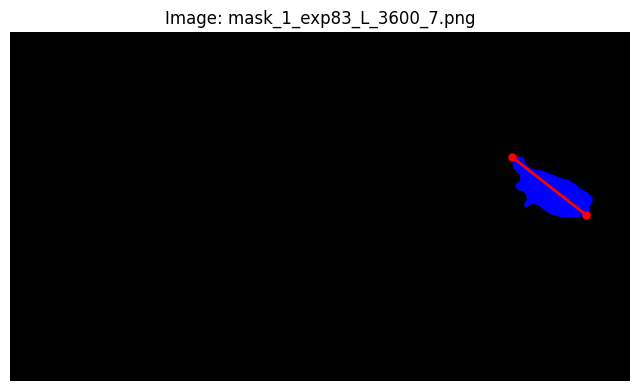

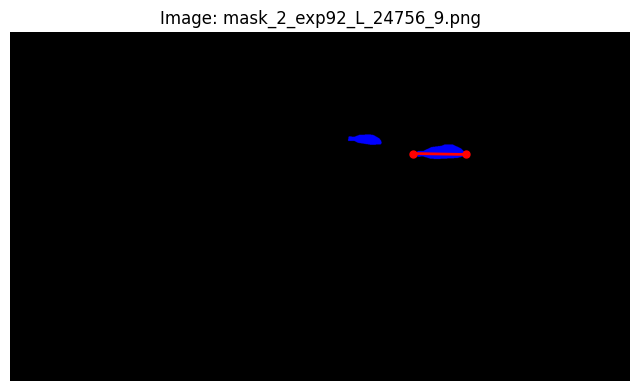

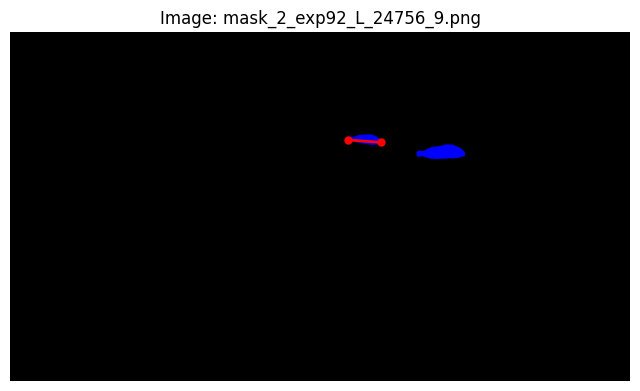

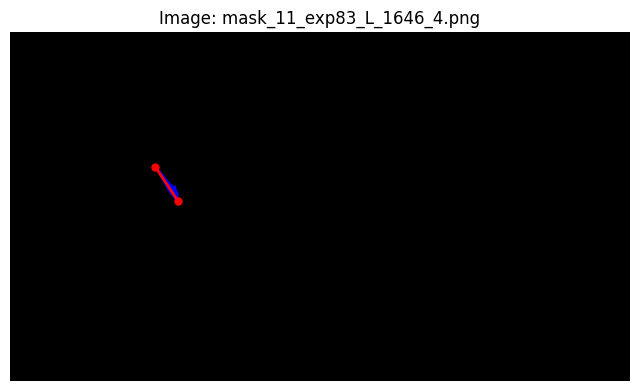

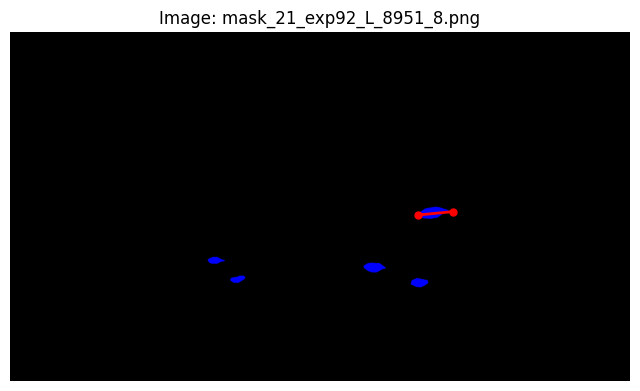

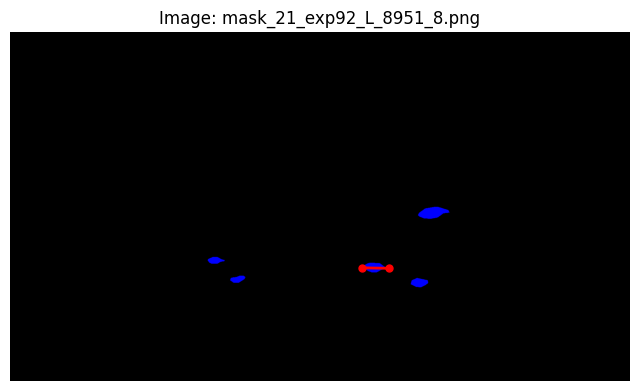

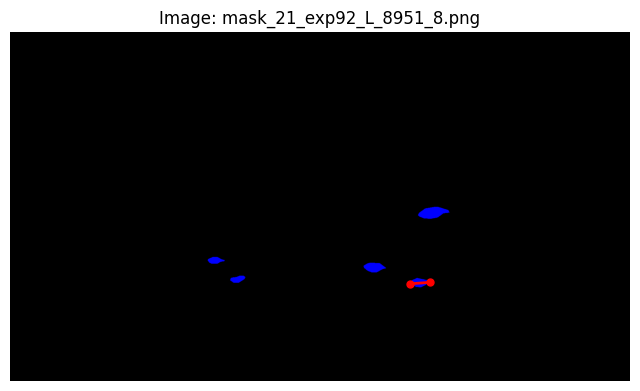

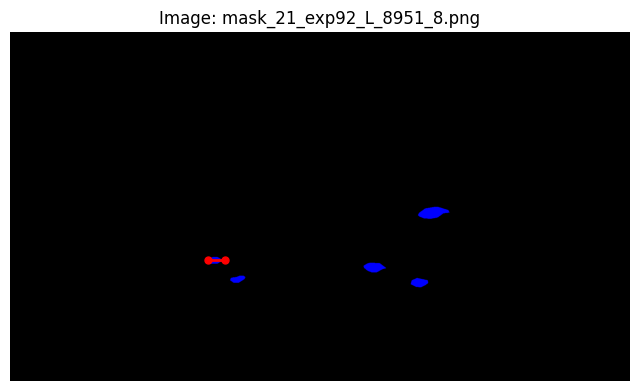

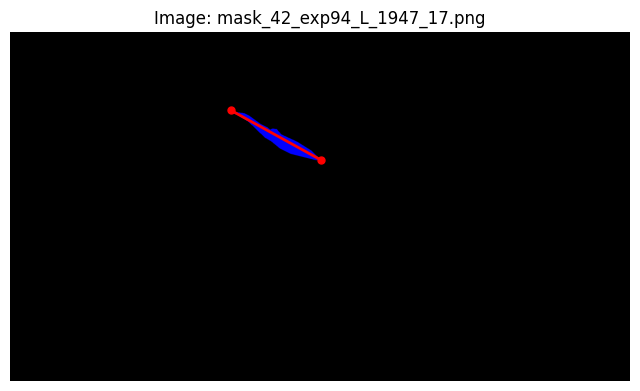

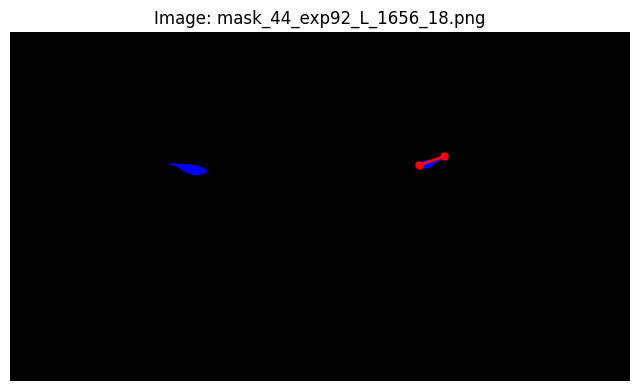

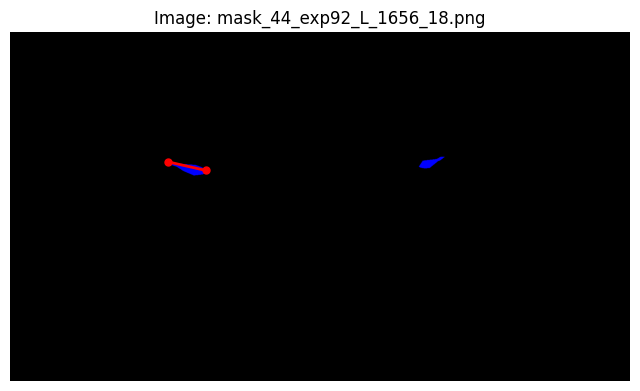

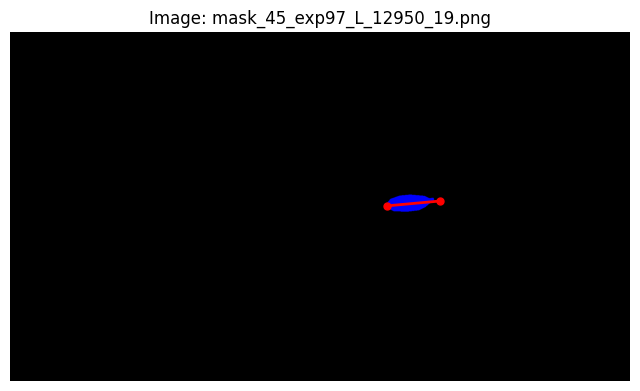

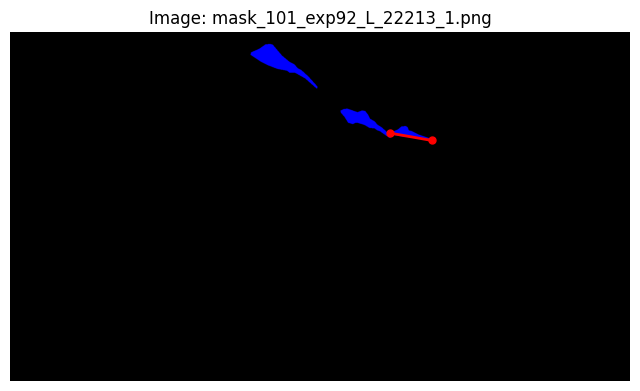

Error in callback <function flush_figures at 0x7fac9cf4e440> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [68]:
# Loop through each row in the CSV
for index, row in data.iterrows():
    mask_name = row["mask_name"]
    mask_path = os.path.join(mask_directory, mask_name)

    # Check if the image exists
    if os.path.exists(mask_path):
        # Open the image
        mask = Image.open(mask_path)

        # Create a new figure for each image to avoid overlapping plots
        plt.figure(figsize=(8, 8))
        
        # Plot the image
        plt.imshow(mask)

        # Extract coordinates
        Lx0, Ly0, Lx1, Ly1 = row["Lx0"], row["Ly0"], row["Lx1"], row["Ly1"]

        # Plot the coordinates
        plt.plot(
            [Lx0, Lx1],
            [Ly0, Ly1],
            marker="o",
            color="red",
            linestyle="-",
            linewidth=2,
            markersize=5,
        )

        # Display the image with points
        plt.title(f"Image: {mask_name}")
        plt.axis("off")  # Hide axes
        plt.show()
        
    else:
        print(f"Image {mask_name} not found in folder.")
        print(mask_path)


In [12]:
# Loops over images to get metadata
for img_id in image_ids:
    img_info = coco.loadImgs(img_id)[0]  # Receive Image ID's
    img_name = os.path.splitext(img_info['file_name'])[0]  # Receive Image names and strip .extension
    ann_ids = coco.getAnnIds(imgIds=img_id)  # Receive Annotation ID's
    anns = coco.loadAnns(ann_ids)  # Load the received Annotation ID's

    # Initialize an empty mask for the entire image (with the same dimensions as the image)
    full_mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    # Loops over annotations in each image    
    for ann in anns:
        segmentation = ann['segmentation']
        
        if isinstance(segmentation, list):  # Polygon format
            mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
            # Convert polygons to a mask
            for poly in segmentation:
                poly = np.array(poly).reshape((-1, 2))  # Reshape to (N, 2)
                cv2.fillPoly(mask, [np.int32(poly)], 1)  # Fill the polygon with 1's

        elif isinstance(segmentation, dict) and 'counts' in segmentation:  # RLE format
            rle = segmentation
            if isinstance(rle['counts'], list):  # Uncompressed RLE
                rle = maskUtils.frPyObjects([rle], img_info['height'], img_info['width'])
            mask = maskUtils.decode(rle)  # Decode RLE to binary mask

        else:
            continue  # Skip if segmentation format is not recognized

        # Ensure mask has the same shape as full_mask by removing the extra dimension if necessary
        if len(mask.shape) == 3 and mask.shape[2] == 1:
            mask = np.squeeze(mask, axis=2)  # Remove the third dimension

        # Combine the individual mask with the full mask (add the masks together)
        full_mask = np.maximum(full_mask, mask)  # Ensures the combination of all masks
    
    # Choose a color for the mask (RGB format, e.g., red (255, 0, 0))
    mask_color = (255, 0, 0)  # Red color for the mask, you can change it to any RGB color

    # Apply the color to the combined binary mask
    colored_mask = apply_color_mask(full_mask, mask_color)

    # Display the colored mask with all annotations combined
    # plt.figure(figsize=(10, 10))
    # plt.imshow(colored_mask)
    # plt.axis('on')
    # plt.show()

    # Save the colored mask
    mask_filename = os.path.join(mask_directory, f"mask_{img_name}_{img_id}.png")
    # cv2.imwrite(mask_filename, colored_mask)  # Save the mask as an RGB image
    print(f"Image name: {img_name} | Image ID: {img_id} | Anno ID: {ann_ids} as {mask_filename}")

Image name: 101_exp92_L_22213 | Image ID: 1 | Anno ID: [1, 2, 3] as ../data/depth-anything-v2-set2/masks/mask_101_exp92_L_22213_1.png
Image name: 105_exp96_L_11815 | Image ID: 2 | Anno ID: [4] as ../data/depth-anything-v2-set2/masks/mask_105_exp96_L_11815_2.png
Image name: 116_exp92_L_2546 | Image ID: 3 | Anno ID: [5] as ../data/depth-anything-v2-set2/masks/mask_116_exp92_L_2546_3.png
Image name: 11_exp83_L_1646 | Image ID: 4 | Anno ID: [6] as ../data/depth-anything-v2-set2/masks/mask_11_exp83_L_1646_4.png
Image name: 130_exp96_L_15036 | Image ID: 5 | Anno ID: [7] as ../data/depth-anything-v2-set2/masks/mask_130_exp96_L_15036_5.png
Image name: 1_exp83_L_3542 | Image ID: 6 | Anno ID: [8] as ../data/depth-anything-v2-set2/masks/mask_1_exp83_L_3542_6.png
Image name: 1_exp83_L_3600 | Image ID: 7 | Anno ID: [9] as ../data/depth-anything-v2-set2/masks/mask_1_exp83_L_3600_7.png
Image name: 21_exp92_L_8951 | Image ID: 8 | Anno ID: [10, 11, 12, 13] as ../data/depth-anything-v2-set2/masks/mask_2